#  How to perform functional enrichment analysis on Chip-Seq data?
# Test the enrichment of some functional categories close to topoisomerase I peaks

Please use the next cell to adjust the two following variables according to your installation: 
- path to GRATIOSA package
- path to database

In [1]:
import sys
## PATH TO PACKAGE:
## ----------------
## IF ALREADY IN YOUR PYTHON PATH (e.g. installation through Pip): nothing to do
## IF NOT IN YOUR PYTHON PATH (e.g. download from GitHub): 
## uncomment and adjust the following relevant line to the location of the GRATIOSA directory
## - For Linux/MacOS:             typical style ;-)
#sys.path.append('/home/usr/Python_venv/lib/python3.8/site-packages/') 
#sys.path.append("/home/s/Téléchargements/GRATIOSA-master/")
sys.path.append("/home/s/Downloads/GRATIOSA-master/")
## (- For Windows:                  typical style ;-)
#sys.path.append('C:\\Downloads\\GRATIOSA-master')

import os
## PATH TO DATABASE:
## -----------------
## FOR REGULAR USE OF THE PACKAGE:
#  Please set your system environment variable \$GRATIOSA_DB_PATH in order to have 
#  \$GRATIOSA_DB_PATH + data/organisms (e.g. export GRATIOSA_DB_PATH=/home/usr/documents/GRATIOSA/).
## FOR THIS TUTORIAL ONLY:
#  you can skip the system environment variable and just use the following line
#  We assume that the "data" directory containing the database is in the parent directory (otherwise adjust line)
os.environ["GRATIOSA_DB_PATH"]=os.getcwd()+"/../"
print("Please check that the database is stored in: %s"%(os.environ["GRATIOSA_DB_PATH"]))

Please check that the database is stored in: /home/s/maiwenn_PhD/article_GRATIOSA/test_GRATIOSA/GRATIOSA-master/tutorials/../


In [10]:
# Loading the modules for data loading
from GRATIOSA import Genome, Chipseq, GO

# Loading the statistical analysis and graphic modules
from GRATIOSA import stat_analysis, plot_stat_analysis
import numpy as np

## 1 - Data loading
#### Genomic annotation loading

In [3]:
g = Genome.Genome("ecoli_W3110_Mu")
g.load_seq()
g.load_annotation()

Trying to load annotation from: /home/s/maiwenn_PhD/article_GRATIOSA/test_GRATIOSA/GRATIOSA-master/tutorials/../data/ecoli_W3110_Mu/annotation/sequence.gff3
Annotation loaded


#### ChipSeq signal loading for topoisomerase I

In [4]:
# Initialization of the Chipseq object
ch = Chipseq.Chipseq("ecoli_W3110_Mu")

# Selection of replicates 
cond =["Sutormin_TopoI_R1", "Sutormin_TopoI_R2", "Sutormin_TopoI_R3"]

# The load_signal_average method performs the following two steps:
# 1 - Processes each replicate (here, binning with a chosen binsize)
# 2 - Calculates the average signal between replicates for each genomic position, to reduce noise
binsize = 100  # Choice of the binsize (in b) for the binning
cond_name = f"Topo_bin{binsize}b" # Choice of the new signal name
ch.load_signals_average(list_cond=cond,  # automatic computation of average between the chosen list of samples
                        average_name=cond_name,
                        data_treatment="binning",
                        binsize=binsize)
signal_per_bin = ch.signals_average[cond_name][np.arange(0,g.length,binsize)]  # for facility, give a simple name

loading the file obtained with the following parameters:

Name: Topo_bin100b

 Replicates: ['Sutormin_TopoI_R1', 'Sutormin_TopoI_R2', 'Sutormin_TopoI_R3']

 Data treatment: binning

 Size (window or bin, in b): 100

Please change 'average_name' to use other signals


## 2 - Simplified peak calling and gene selection

#### Selection of bins with strongest topoisomerase binding signal using the built-in data classification function

In [5]:
nb_peaks = 100 # Choice of the number of strong peaks to keep as a separate class 

# Use an automatic function to classify ChIP-Seq bins into classes according to binding strength, with chosen size
# Here, only two classes: [0] almost all bins; [1] 100 strongest bins
peaks_bin = stat_analysis.data_classification(np.arange(len(signal_per_bin)),
                                              signal_per_bin,
                                              class_nb = 2, 
                                              class_sizes = [len(signal_per_bin)-nb_peaks,nb_peaks]
                                             )[0][1]

0: 46375 elements
1: 100 elements


#### Gene selection (2 options):
+ A: Selection of genes within a chosen window size around each enriched bin

In [6]:
ws = 400 #Choice of the window size ws (in b). 

#Genes located between the start of the peak - ws and the end of the peak + ws are selected
g.load_genes_per_pos(ws*2+binsize)

peak_genes = []
for i in peaks_bin :
    genes = g.genes_per_pos[i*binsize]
    if genes != [None] : 
        peak_genes.extend(genes)
peak_genes =  list(dict.fromkeys(peak_genes))
nopeak_genes = [i for i in list(g.genes.keys()) if i not in peak_genes]

+ B: Selection of the 2 closest genes to each enriched bin

In [7]:
g.load_neighbor_all() #Load, for each position, the closest right and left neighbors

neighbor_genes = []
for i in peaks_bin :
    neighbor_genes.extend([g.left_neighbor[i*binsize],g.right_neighbor[i*binsize]])
neighbor_genes =  list(dict.fromkeys(neighbor_genes))
notneighbor_genes = [i for i in list(g.genes.keys()) if i not in neighbor_genes]

## 3 - Functional enrichment analysis (GO annotation)

#### GO annotation loading

In [8]:
g.load_GO()
dict_GO = g.GO['GO']

Loading GO...
	3739 genes were successfully associated with some GO terms
	927 genes were not associated with any GO term


#### Functional enrichment analysis

In [11]:
genes = {"Peak" : peak_genes, "No peak" : nopeak_genes}  # gene selection made with option A
# genes = {"Peak" : neighbor_genes, "No peak" : notneighbor_genes} # gene selection made with option B

# Performs enrichment analysis (after automatic download of the updated GO descriptor file)
# Exports 3 csv files (GOc, GOp, GOf), with enrichment test for each function. 
GO.GO_enrichment_test(dict_GO,genes,"Peak",obo_reload=True,
                      output_file=f"GO_enrichment_bin{binsize}b_{nb_peaks}peaks")

--2023-12-22 18:26:40--  http://purl.obolibrary.org/obo/go/go-basic.obo
Resolving purl.obolibrary.org (purl.obolibrary.org)... 2606:4700:4400::ac40:96c5, 2606:4700:4400::6812:253b, 104.18.37.59, ...
Connecting to purl.obolibrary.org (purl.obolibrary.org)|2606:4700:4400::ac40:96c5|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://current.geneontology.org/ontology/go-basic.obo [following]
--2023-12-22 18:26:40--  http://current.geneontology.org/ontology/go-basic.obo
Resolving current.geneontology.org (current.geneontology.org)... 2600:9000:244d:400:d:ff6c:c780:93a1, 2600:9000:244d:7000:d:ff6c:c780:93a1, 2600:9000:244d:5800:d:ff6c:c780:93a1, ...
Connecting to current.geneontology.org (current.geneontology.org)|2600:9000:244d:400:d:ff6c:c780:93a1|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31136976 (30M) [text/obo]
Saving to: ‘/home/s/maiwenn_PhD/article_GRATIOSA/test_GRATIOSA/GRATIOSA-master/tutorials/../data/go-basic.obo’

 

  5050K .......... .......... .......... .......... .......... 16% 5,03M 11s
  5100K .......... .......... .......... .......... .......... 16% 7,44M 11s
  5150K .......... .......... .......... .......... .......... 17% 7,52M 11s
  5200K .......... .......... .......... .......... .......... 17% 7,42M 11s
  5250K .......... .......... .......... .......... .......... 17% 7,51M 11s
  5300K .......... .......... .......... .......... .......... 17% 7,50M 10s
  5350K .......... .......... .......... .......... .......... 17% 7,48M 10s
  5400K .......... .......... .......... .......... .......... 17% 14,6M 10s
  5450K .......... .......... .......... .......... .......... 18% 7,45M 10s
  5500K .......... .......... .......... .......... .......... 18% 5,02M 10s
  5550K .......... .......... .......... .......... .......... 18% 14,9M 10s
  5600K .......... .......... .......... .......... .......... 18% 7,47M 10s
  5650K .......... .......... .......... .......... .......... 18% 7,52M 10s

 11350K .......... .......... .......... .......... .......... 37% 7,53M 5s
 11400K .......... .......... .......... .......... .......... 37% 16,3M 5s
 11450K .......... .......... .......... .......... .......... 37% 14,8M 5s
 11500K .......... .......... .......... .......... .......... 37% 15,0M 5s
 11550K .......... .......... .......... .......... .......... 38% 14,7M 5s
 11600K .......... .......... .......... .......... .......... 38% 15,6M 5s
 11650K .......... .......... .......... .......... .......... 38% 14,4M 5s
 11700K .......... .......... .......... .......... .......... 38% 15,5M 4s
 11750K .......... .......... .......... .......... .......... 38% 15,0M 4s
 11800K .......... .......... .......... .......... .......... 38% 14,3M 4s
 11850K .......... .......... .......... .......... .......... 39% 15,4M 4s
 11900K .......... .......... .......... .......... .......... 39% 15,1M 4s
 11950K .......... .......... .......... .......... .......... 39% 14,9M 4s
 12000K ....

 18000K .......... .......... .......... .......... .......... 59%  779K 2s
 18050K .......... .......... .......... .......... .......... 59%  286M 2s
 18100K .......... .......... .......... .......... .......... 59% 7,34M 2s
 18150K .......... .......... .......... .......... .......... 59% 15,7M 2s
 18200K .......... .......... .......... .......... .......... 60% 7,56M 2s
 18250K .......... .......... .......... .......... .......... 60%  388M 2s
 18300K .......... .......... .......... .......... .......... 60%  169M 2s
 18350K .......... .......... .......... .......... .......... 60% 8,00M 2s
 18400K .......... .......... .......... .......... .......... 60% 15,1M 2s
 18450K .......... .......... .......... .......... .......... 60%  177M 2s
 18500K .......... .......... .......... .......... .......... 61%  162M 2s
 18550K .......... .......... .......... .......... .......... 61% 7,87M 2s
 18600K .......... .......... .......... .......... .......... 61% 16,5M 2s
 18650K ....

 24950K .......... .......... .......... .......... .......... 82% 15,5M 1s
 25000K .......... .......... .......... .......... .......... 82%  237M 1s
 25050K .......... .......... .......... .......... .......... 82% 7,50M 1s
 25100K .......... .......... .......... .......... .......... 82% 16,0M 1s
 25150K .......... .......... .......... .......... .......... 82% 14,5M 1s
 25200K .......... .......... .......... .......... .......... 83%  203M 1s
 25250K .......... .......... .......... .......... .......... 83% 16,7M 1s
 25300K .......... .......... .......... .......... .......... 83% 15,0M 1s
 25350K .......... .......... .......... .......... .......... 83% 7,44M 1s
 25400K .......... .......... .......... .......... .......... 83%  198M 1s
 25450K .......... .......... .......... .......... .......... 83% 16,3M 1s
 25500K .......... .......... .......... .......... .......... 84%  213M 1s
 25550K .......... .......... .......... .......... .......... 84% 15,6M 1s
 25600K ....

Results saved in /home/s/maiwenn_PhD/article_GRATIOSA/test_GRATIOSA/GRATIOSA-master/tutorials/../resdir/enrichment_test/GO_enrichment_bin100b_100peaks_GOc.csv
Results saved in /home/s/maiwenn_PhD/article_GRATIOSA/test_GRATIOSA/GRATIOSA-master/tutorials/../resdir/enrichment_test/GO_enrichment_bin100b_100peaks_GOp.csv
Results saved in /home/s/maiwenn_PhD/article_GRATIOSA/test_GRATIOSA/GRATIOSA-master/tutorials/../resdir/enrichment_test/GO_enrichment_bin100b_100peaks_GOf.csv
Results saved in /home/s/maiwenn_PhD/article_GRATIOSA/test_GRATIOSA/GRATIOSA-master/tutorials/../resdir/enrichment_test/GO_enrichment_bin100b_100peaks_significant.csv


#### Visualization of some enrichment results

GO:0009103: 56 valid elements
GO:0045226: 12 valid elements
GO:0015774: 5 valid elements
Results saved in /home/s/maiwenn_PhD/article_GRATIOSA/test_GRATIOSA/GRATIOSA-master/tutorials/../resdir/enrichment_test/test1.csv
     Category  Selected_gene_nb  Expected_selected_nb  Adj p-value (FDR)
0  GO:0009103                 9              0.778818       1.311891e-07
1  GO:0045226                 0              0.166890       1.000000e+00
2  GO:0015774                 0              0.069537       1.000000e+00
     Category  Selected_gene_nb  Total_gene_nb  Proportion     Prop_conf_int  \
0  GO:0009103                 9             56    0.160714  [0.1339, 0.1875]   
1  GO:0045226                 0             12    0.000000     [0.0, 0.0417]   
2  GO:0015774                 0              5    0.000000        [0.0, 0.1]   

        p-value  Adj p-value (FDR)  Global_proportion  Expected_selected_nb  
0  4.372971e-08       1.311891e-07           0.013907              0.778818  
1  1.000000e

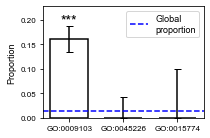

In [12]:
# Plot the proportion of genes of different GO terms, which belong to the selected group 
# (here close to high topoisomerase I peaks)
# and perform an enrichment test to compare it to the genomic average (here around 0.02%)
plot_stat_analysis.plot_enrichment_test(
    dict_GO,genes,
    targ_features=["Peak"],
    targ_cats=["GO:0009103","GO:0045226","GO:0015774"],
    figsize = (3,2),
    output_file="test1")